In [ ]:
import sys
sys.path.append('..')

import pandas as pd
import numpy as np

import src.data_pipeline # data pipeline

from sklearn.decomposition import PCA # Clustering
from sklearn.preprocessing import StandardScaler
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
import scipy.cluster.hierarchy as sch
from scipy.spatial.distance import pdist
from sklearn.cluster import AgglomerativeClustering

# Visualization
from matplotlib import pyplot as plt
import seaborn as sns


In [2]:
fighter_df = src.data_pipeline.force_reprocess()

INFO:src.data_pipeline:Cleared cached data - reprocessing...
INFO:src.data_pipeline:Processing UFC fighter data...
INFO:src.data_pipeline:Using raw data: raw
INFO:src.data_pipeline:Using processed data: processed
INFO:src.data_pipeline:Processing raw data...
INFO:src.processing.data_processor:Data loaded successfully. 8250 events, 2598 fighters, 8250 fights.
INFO:src.processing.pre_processor:Standardizing data types and values...
INFO:src.processing.pre_processor:Calculating fight time corrections...
INFO:src.processing.pre_processor:Excluded 146 fights with non-binary outcomes (draws/no contests/etc.)
INFO:src.processing.pre_processor:Performing data validation...
INFO:src.processing.pre_processor:Pre-processing complete. Shape: (8250, 86) -> (8104, 90)
INFO:src.processing.metric_calculator:Adding complementary fight metrics...
INFO:src.processing.data_processor:Preparing fight-level data from preprocessed inputs...
INFO:src.processing.data_processor:✓ Prepared fighter-level data: 162

# Exploratory Graphs

In [5]:
for col in fighter_df.columns: print(col)

id
total_UFC_fights
UFC_wins
UFC_losses
last_fight
total_fight_time_sec
total_rounds_fought
kd
sig_str_landed
sig_str_atmpted
total_str_landed
total_str_atmpted
td_landed
td_atmpted
ctrl
sub_att
head_landed
head_atmpted
body_landed
body_atmpted
leg_landed
leg_atmpted
dist_landed
dist_atmpted
clinch_landed
clinch_atmpted
ground_landed
ground_atmpted
sig_str_absorbed
total_str_absorbed
takedowns_allowed
time_controlled
knockdowns_absorbed
takedowns_defended
subs_defended
head_absorbed
body_absorbed
leg_absorbed
dist_absorbed
clinch_absorbed
ground_absorbed
ctrl_differential
str_differential
opp_sig_str_landed
opp_takedowns_landed
name
division
wins_by_ko_tko
losses_by_ko_tko
wins_by_submission
losses_by_submission
wins_by_decision
losses_by_decision
wins_by_other
losses_by_other
career_total_sig_str_acc
career_total_str_acc
career_td_acc
career_head_acc
career_body_acc
career_leg_acc
career_dist_acc
career_clinch_acc
career_ground_acc
str_landed_per_min
td_per_min
td_att_per_min
kd_per_m

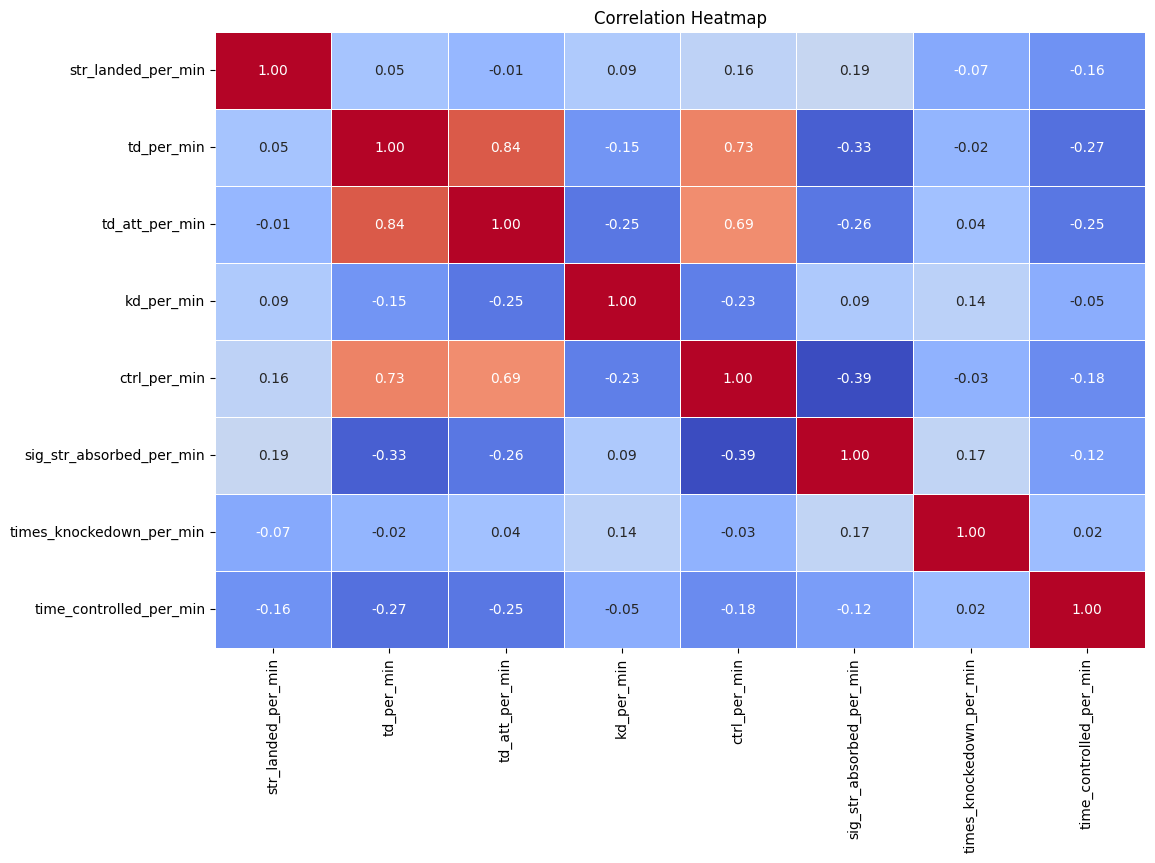

In [6]:
# Exploratory Graphs
corr_columns = ['str_landed_per_min','td_per_min','td_att_per_min','kd_per_min','ctrl_per_min',
                'sig_str_absorbed_per_min','times_knockedown_per_min','time_controlled_per_min']

# Compute correlation matrix
corr_matrix = fighter_df[corr_columns].corr()

# Create a heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5, cbar = False)

plt.title('Correlation Heatmap')
plt.show()

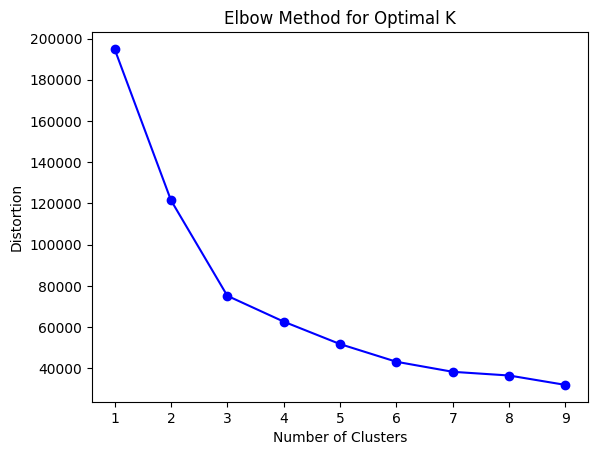

In [7]:
distortions = []
K = range(1, 10)
for k in K:
    kmeans = KMeans(n_clusters=k, n_init='auto')
    kmeans.fit(fighter_df[corr_columns])
    distortions.append(kmeans.inertia_)

plt.plot(K, distortions, 'bo-')
plt.xlabel('Number of Clusters')
plt.ylabel('Distortion')
plt.title('Elbow Method for Optimal K')
plt.show()